In [ ]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset, random_split, DataLoader, Subset
import matplotlib.pyplot as plt
import wandb

In [ ]:
class CNN(nn.Module):
    def __init__(self, cnn_nr=2, kernel_sizes=[], channels=[], dense_nr=2, dense_sizes=[], dropout_cnn = [], dropout_dense = [], use_batchnorm = False):
        super(CNN, self).__init__()

        self.cnn_layers = nn.ModuleList()
        self.dense_layers = nn.ModuleList()

        # CNN
        for nr in range(cnn_nr):
            kernel = kernel_sizes[nr]
            in_channels = channels[nr]
            out_channels = channels[nr + 1]
            padding = (kernel - 1) // 2
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel, padding=padding),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Dropout(dropout_cnn[nr]) if len(dropout_cnn) > nr else nn.Identity()
            )

            self.cnn_layers.append(block)

        ## Linear Dense
        for nr in range(dense_nr):
            in_features = dense_sizes[nr]
            out_features = dense_sizes[nr + 1]
            block = nn.Sequential(
                nn.Linear(in_features, out_features),
                nn.ReLU(),
                nn.BatchNorm1d(out_features) if use_batchnorm else nn.Identity(),
                nn.Dropout(dropout_dense[nr]) if len(dropout_dense) > nr else nn.Identity()
            )
            self.dense_layers.append(block)

    def forward(self, x):
        for layer in self.cnn_layers:
            x = layer(x)

        x = nn.Flatten()(x)

        for layer in self.dense_layers:
            x = layer(x)
        return x

In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()

        ## CNN
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        ## Linear Dense
        self.dense = nn.Sequential(
            nn.Linear(256 * 5 * 5, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 102)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = torch.flatten(x, 1)
        x = self.dense(x)
        return x

In [ ]:
def load_data(limit_train=1.0, augmentation = False, batch_size = 64):
    transform_actions = [
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]

    if augmentation:
        transform_actions.extend([
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.RandomAffine(
                degrees=10,
                translate=(0.1, 0.1),
                scale=(0.9, 1.1)
            ),
        ])

    transform = transforms.Compose(transform_actions)
    train = torchvision.datasets.Flowers102(root='./data', split="train", download=True, transform=transform)
    test = torchvision.datasets.Flowers102(root='./data', split="test", download=True, transform=transform)
    val = torchvision.datasets.Flowers102(root='./data', split="val", download=True, transform=transform)
    train_size = len(train)
    test_size = len(test)

    ## limit
    if 0 < limit_train < 1.0:
        train_len = int(len(train) * limit_train)
        train = Subset(train, list(range(train_len)))

    ## move from test to train
    elif limit_train > 1.0:
        train_extra_len = int(len(train) * (limit_train - 1.0))

        train_extra_len = min(train_extra_len, len(test))
        indices = list(range(train_extra_len))
        extra_train = Subset(test, indices)

        train = ConcatDataset([train, extra_train])
        test = Subset(test, list(range(train_extra_len, len(test))))

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val, batch_size=batch_size)
    test_loader = DataLoader(test, batch_size=batch_size)

    return train_loader, val_loader, test_loader


In [ ]:
def train_model(model, train_loader, val_loader, epoch=15, lr=0.001, early_stop = 2, optimizer = "Adam", project_name = "", run_name = "", model_name = "model"):
    def plot_history(train_losses, val_losses):
        epochs = list(range(len(train_losses)))
        plt.figure(figsize=(8, 5))
        plt.plot(epochs, train_losses, marker='o', label='Train Loss')
        plt.plot(epochs, val_losses, marker='s', label='Validation Loss')
        plt.title('Avg loss over epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    run = wandb.init(project=project_name, name=run_name,
    config = {
        "lr": lr,
        "epoch": epoch,
        "optimizer": optimizer,
    })

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.to(device)

    loss_fun = nn.CrossEntropyLoss()
    if optimizer == "Adam":
      optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer == "SGD":
      optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    train_history = []
    val_history = []
    early_stop_iter = early_stop
    for nr in range(epoch):
        model.train()
        train_loss = 0
        for X, y in train_loader:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            predicted = model(X)
            loss = loss_fun(predicted, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                predicted = model(X)
                loss = loss_fun(predicted, y)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        train_history.append(avg_train_loss)
        val_history.append(avg_val_loss)

        wandb.log({
            "train_loss": avg_train_loss,
            "val_accuracy": avg_val_loss,
            "epoch": epoch
        })

        print(f"Epoch {nr+1}/{epoch} | Train Loss: {avg_train_loss} | Val Loss: {avg_val_loss}")


        ## early stopping
        if len(val_history) > 2 and val_history[-1] >= val_history[-2]:
          early_stop_iter -= 1
          if early_stop_iter == 0:
            print(f"Early stopping")
            break
        else:
          early_stop_iter = early_stop

    torch.save(model.state_dict(), model_name + ".pth")
    run.save(model_name +".pth")
    run.finish()

    plot_history(train_history, val_history)


In [ ]:
def get_acc(model, test_loader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  correct = 0
  total = 0
  model.eval()

  with torch.no_grad():
      for X, y in test_loader:

          X, y = X.to(device), y.to(device)

          predicted = torch.argmax(model(X), dim=1)
          correct += (predicted == y).sum().item()
          total += y.size(0)

  accuracy = correct / total * 100
  return accuracy

In [ ]:
test_model = lambda : CNN(
    cnn_nr=4,
    kernel_sizes=[5, 5, 3, 3, 3],
    channels=[3, 16, 32, 64, 128],
    dense_nr=3,
    dense_sizes=[21632, 5000, 1024,102])

val_acc = []
train_acc = []

## Train dataset size impact

Epoch 1/15 | Train Loss: 4.140313386917114 | Val Loss: 12.167613416910172
Epoch 2/15 | Train Loss: 4.4312334060668945 | Val Loss: 6.168477296829224
Epoch 3/15 | Train Loss: 3.265909194946289 | Val Loss: 4.884076654911041
Epoch 4/15 | Train Loss: 3.503618001937866 | Val Loss: 5.246783897280693
Epoch 5/15 | Train Loss: 3.3866260051727295 | Val Loss: 6.056157752871513
Early stopping


epoch,▁▁▁▁▁
train_loss,▆█▁▂▂
val_accuracy,█▂▁▁▂
epoch,15
train_loss,3.38663
val_accuracy,6.05616


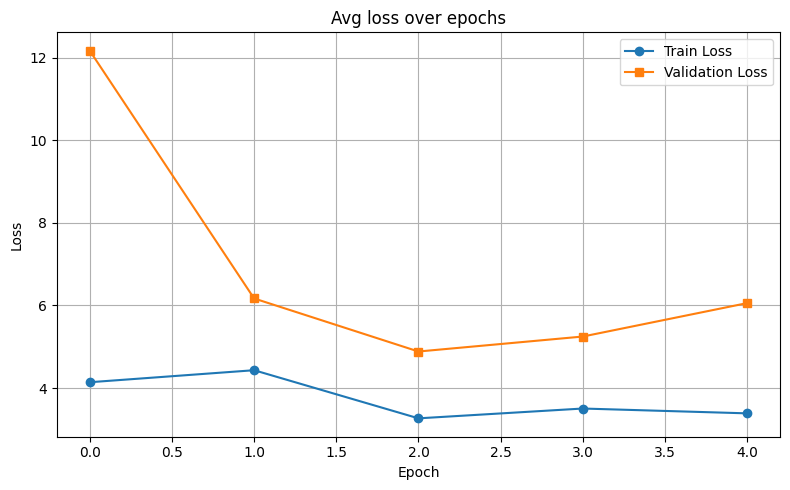

In [ ]:
train_loader, val_loader, test_loader = load_data(limit_train = 0.1)
test_model_0_1 = test_model()

train_model(test_model_0_1, train_loader=train_loader, val_loader=val_loader, project_name = "Flowers102-AlexNet", run_name = "test_model_0_1", model_name = "test_model_0_1")

val_acc.append(get_acc(test_model_0_1, val_loader))
train_acc.append(get_acc(test_model_0_1, train_loader))

Epoch 1/15 | Train Loss: 4.335820198059082 | Val Loss: 5.04764586687088
Epoch 2/15 | Train Loss: 3.8607451915740967 | Val Loss: 5.406993016600609
Epoch 3/15 | Train Loss: 3.67977511882782 | Val Loss: 5.48940934240818
Epoch 4/15 | Train Loss: 3.553093671798706 | Val Loss: 5.8431428372859955
Early stopping


epoch,▁▁▁▁
train_loss,█▄▂▁
val_accuracy,▁▄▅█
epoch,15
train_loss,3.55309
val_accuracy,5.84314


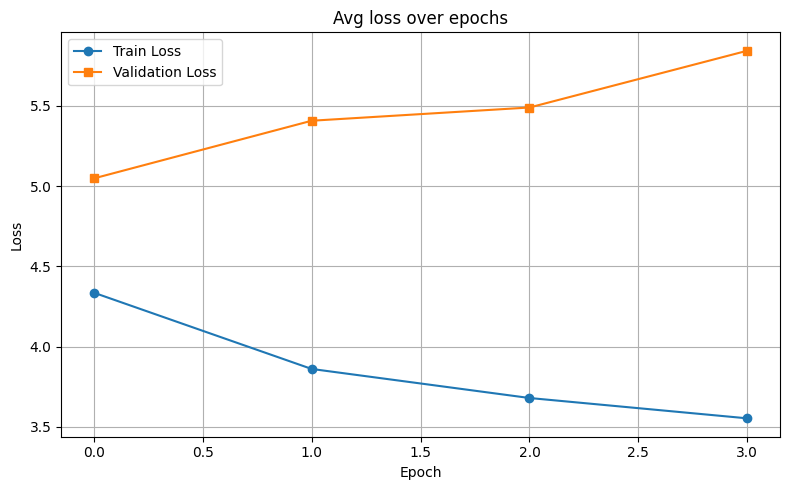

In [ ]:
train_loader, val_loader, test_loader = load_data(limit_train = 0.2)
test_model_0_2 = test_model()
train_model(test_model_0_2, train_loader=train_loader, val_loader=val_loader, project_name = "Flowers102-AlexNet", run_name = "test_model_0_2", model_name = "test_model_0_2")

val_acc.append(get_acc(test_model_0_2, val_loader))
train_acc.append(get_acc(test_model_0_2, train_loader))

Epoch 1/15 | Train Loss: 4.56714653968811 | Val Loss: 4.699372977018356
Epoch 2/15 | Train Loss: 4.473455786705017 | Val Loss: 4.774783492088318
Epoch 3/15 | Train Loss: 4.450803458690643 | Val Loss: 4.831220805644989
Epoch 4/15 | Train Loss: 4.397290945053101 | Val Loss: 4.844095483422279
Early stopping


epoch,▁▁▁▁
train_loss,█▄▃▁
val_accuracy,▁▅▇█
epoch,15
train_loss,4.39729
val_accuracy,4.8441


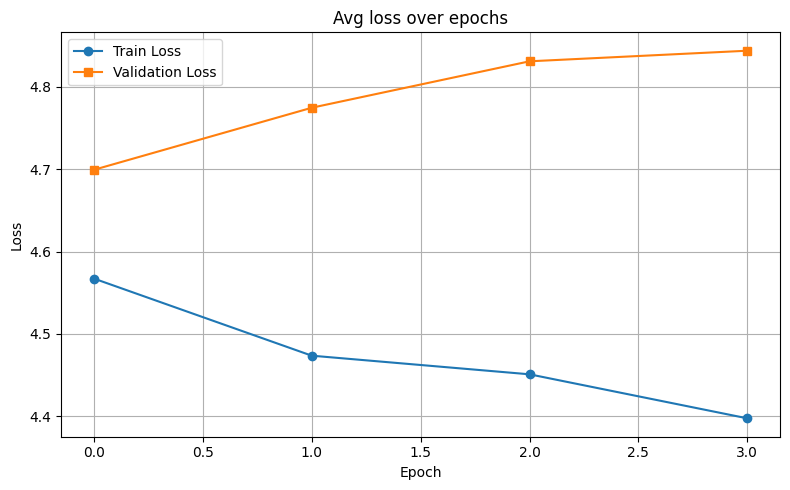

In [ ]:
train_loader, val_loader, test_loader = load_data(limit_train = 0.5)
test_model_0_5 = test_model()
train_model(test_model_0_5, train_loader=train_loader, val_loader=val_loader, project_name = "Flowers102-AlexNet", run_name = "test_model_0_5", model_name = "test_model_0_5")

val_acc.append(get_acc(test_model_0_5, val_loader))
train_acc.append(get_acc(test_model_0_5, train_loader))

Epoch 1/15 | Train Loss: 4.638974923353929 | Val Loss: 4.625085800886154
Epoch 2/15 | Train Loss: 4.625994645632231 | Val Loss: 4.625214636325836
Epoch 3/15 | Train Loss: 4.62318387398353 | Val Loss: 4.625155597925186
Epoch 4/15 | Train Loss: 4.622647835658147 | Val Loss: 4.625489950180054
Epoch 5/15 | Train Loss: 4.620692106393667 | Val Loss: 4.626790404319763
Early stopping


epoch,▁▁▁▁▁
train_loss,█▃▂▂▁
val_accuracy,▁▂▁▃█
epoch,15
train_loss,4.62069
val_accuracy,4.62679


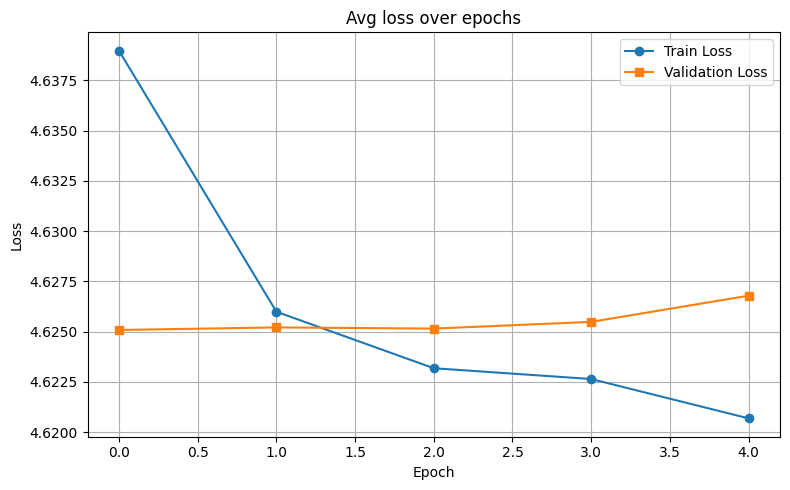

In [ ]:
train_loader, val_loader, test_loader = load_data(limit_train = 0.8)
test_model_0_8 = test_model()
train_model(test_model_0_8, train_loader=train_loader, val_loader=val_loader, project_name = "Flowers102-AlexNet", run_name = "test_model_0_8", model_name = "test_model_0_8")

val_acc.append(get_acc(test_model_0_8, val_loader))
train_acc.append(get_acc(test_model_0_8, train_loader))

Epoch 1/15 | Train Loss: 4.6337830722332 | Val Loss: 4.624324947595596
Epoch 2/15 | Train Loss: 4.623222082853317 | Val Loss: 4.6081511080265045
Epoch 3/15 | Train Loss: 4.59379506111145 | Val Loss: 4.592838257551193
Epoch 4/15 | Train Loss: 4.584918856620789 | Val Loss: 4.574368059635162
Epoch 5/15 | Train Loss: 4.561347961425781 | Val Loss: 4.562952697277069
Epoch 6/15 | Train Loss: 4.5700772404670715 | Val Loss: 4.5546930730342865
Epoch 7/15 | Train Loss: 4.551517456769943 | Val Loss: 4.553825944662094
Epoch 8/15 | Train Loss: 4.536051899194717 | Val Loss: 4.552297443151474
Epoch 9/15 | Train Loss: 4.51678004860878 | Val Loss: 4.543061435222626
Epoch 10/15 | Train Loss: 4.6000956594944 | Val Loss: 4.5943763256073
Epoch 11/15 | Train Loss: 4.563056915998459 | Val Loss: 4.582874685525894
Epoch 12/15 | Train Loss: 4.524670392274857 | Val Loss: 4.5568153858184814
Epoch 13/15 | Train Loss: 4.484721690416336 | Val Loss: 4.545739769935608
Epoch 14/15 | Train Loss: 4.480614930391312 | Val L

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,██▇▆▆▆▅▅▄▇▆▄▃▃▁
val_accuracy,█▇▅▄▃▂▂▂▁▅▄▂▁▂▂
epoch,15
train_loss,4.42167
val_accuracy,4.55111


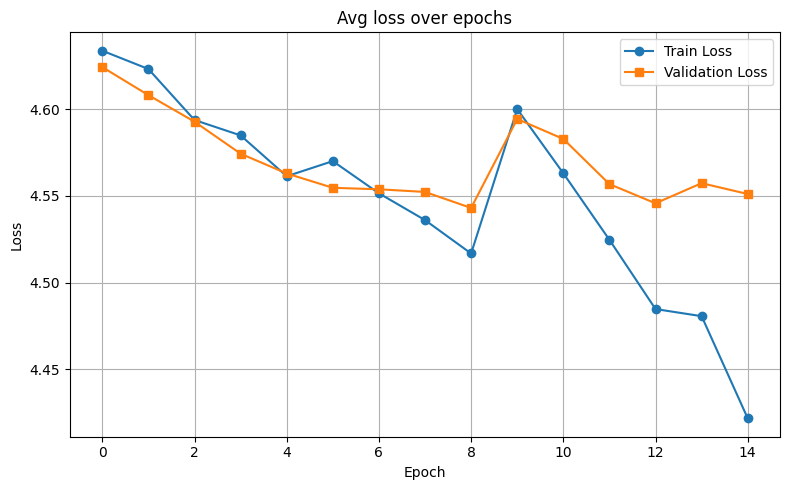

In [ ]:
train_loader, val_loader, test_loader = load_data(limit_train = 1)
test_model_1 = test_model()
train_model(test_model_1, train_loader=train_loader, val_loader=val_loader, project_name = "Flowers102-AlexNet", run_name = "test_model_1", model_name = "test_model_1")

val_acc.append(get_acc(test_model_1, val_loader))
train_acc.append(get_acc(test_model_1, train_loader))

Epoch 1/15 | Train Loss: 4.583415770530701 | Val Loss: 4.684922680258751
Epoch 2/15 | Train Loss: 4.52074031829834 | Val Loss: 4.631618976593018
Epoch 3/15 | Train Loss: 4.4077465534210205 | Val Loss: 4.65386401116848
Epoch 4/15 | Train Loss: 4.371635246276855 | Val Loss: 4.5859542191028595
Epoch 5/15 | Train Loss: 4.4392005681991575 | Val Loss: 4.635613322257996
Epoch 6/15 | Train Loss: 4.34305260181427 | Val Loss: 4.6702447682619095
Early stopping


epoch,▁▁▁▁▁▁
train_loss,█▆▃▂▄▁
val_accuracy,█▄▆▁▅▇
epoch,15
train_loss,4.34305
val_accuracy,4.67024


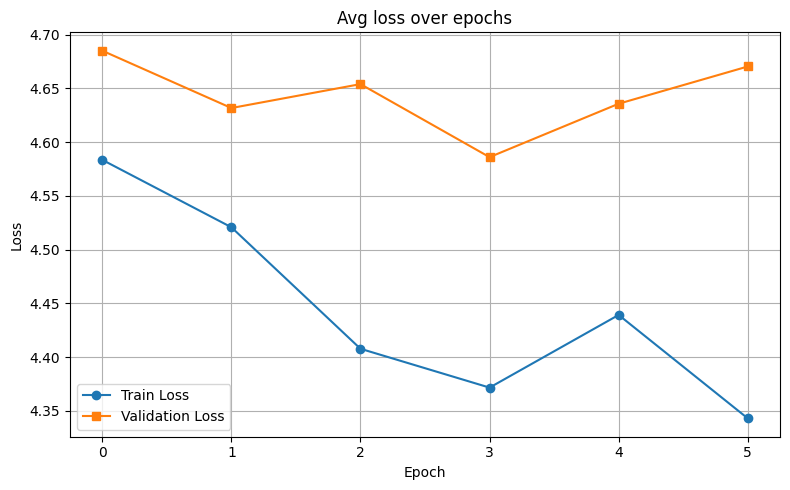

In [ ]:
train_loader, val_loader, test_loader = load_data(limit_train = 1.2)
test_model_1_2 = test_model()
train_model(test_model_1_2, train_loader=train_loader, val_loader=val_loader, project_name = "Flowers102-AlexNet", run_name = "test_model_1_2", model_name = "test_model_1_2")

val_acc.append(get_acc(test_model_1_2, val_loader))
train_acc.append(get_acc(test_model_1_2, train_loader))

Epoch 1/15 | Train Loss: 4.515665094057719 | Val Loss: 4.680651307106018
Epoch 2/15 | Train Loss: 4.451188623905182 | Val Loss: 4.684824392199516
Epoch 3/15 | Train Loss: 4.336486279964447 | Val Loss: 4.694524452090263
Epoch 4/15 | Train Loss: 4.302483628193538 | Val Loss: 4.713686406612396
Early stopping


epoch,▁▁▁▁
train_loss,█▆▂▁
val_accuracy,▁▂▄█
epoch,15
train_loss,4.30248
val_accuracy,4.71369


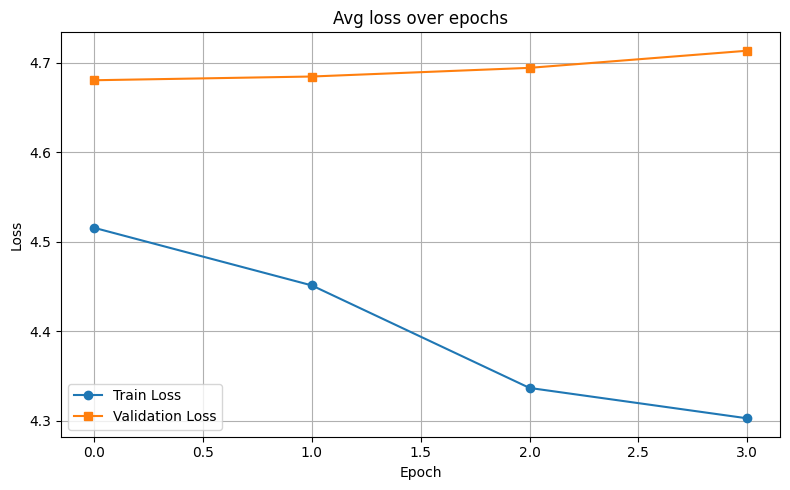

In [ ]:
train_loader, val_loader, test_loader = load_data(limit_train = 1.5)
test_model_1_5 = test_model()
train_model(test_model_1_5, train_loader=train_loader, val_loader=val_loader, project_name = "Flowers102-AlexNet", run_name = "test_model_1_5", model_name = "test_model_1_5")

val_acc.append(get_acc(test_model_1_5, val_loader))
train_acc.append(get_acc(test_model_1_5, train_loader))

Epoch 1/15 | Train Loss: 4.586053946922565 | Val Loss: 4.685273736715317
Epoch 2/15 | Train Loss: 4.472302436828613 | Val Loss: 4.732087165117264
Epoch 3/15 | Train Loss: 4.4572751110997695 | Val Loss: 4.713063031435013
Epoch 4/15 | Train Loss: 4.447390441236825 | Val Loss: 4.678846925497055
Epoch 5/15 | Train Loss: 4.409102193240462 | Val Loss: 4.735942617058754
Epoch 6/15 | Train Loss: 4.316873550415039 | Val Loss: 4.68446809053421
Epoch 7/15 | Train Loss: 4.216992961949315 | Val Loss: 4.682992801070213
Epoch 8/15 | Train Loss: 4.064462415103255 | Val Loss: 4.579235374927521
Epoch 9/15 | Train Loss: 3.9894426526694464 | Val Loss: 4.633115574717522
Epoch 10/15 | Train Loss: 3.891957932505114 | Val Loss: 4.6176935732364655
Epoch 11/15 | Train Loss: 3.7731466457761567 | Val Loss: 4.582442477345467
Epoch 12/15 | Train Loss: 3.7006498123037406 | Val Loss: 4.687312752008438
Epoch 13/15 | Train Loss: 3.5625550746917725 | Val Loss: 4.570136845111847
Epoch 14/15 | Train Loss: 3.44781782709319

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▇▇▆▆▅▅▄▃▃▂▂▁
val_accuracy,▇█▇▆█▇▇▄▅▅▄▇▃▁▃
epoch,15
train_loss,3.34191
val_accuracy,4.55691


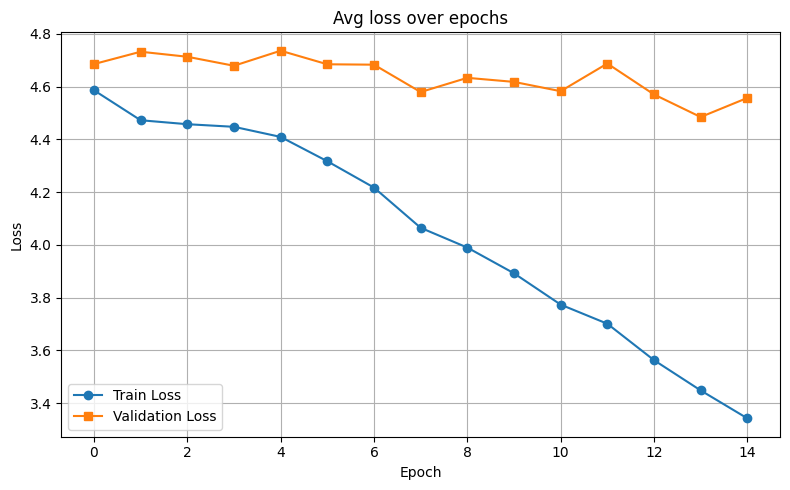

In [ ]:
train_loader, val_loader, test_loader = load_data(limit_train = 1.8)
test_model_1_8 = test_model()
train_model(test_model_1_8, train_loader=train_loader, val_loader=val_loader, project_name = "Flowers102-AlexNet", run_name = "test_model_1_8", model_name = "test_model_1_8")

val_acc.append(get_acc(test_model_1_8, val_loader))
train_acc.append(get_acc(test_model_1_8, train_loader))

[0.9803921568627451, 0.9803921568627451, 1.5686274509803921, 0.9803921568627451, 4.901960784313726, 2.3529411764705883, 2.2549019607843137, 8.333333333333332]
[9.803921568627452, 4.901960784313726, 5.88235294117647, 1.2254901960784315, 9.019607843137255, 10.629599345870808, 11.241830065359478, 31.590413943355124]


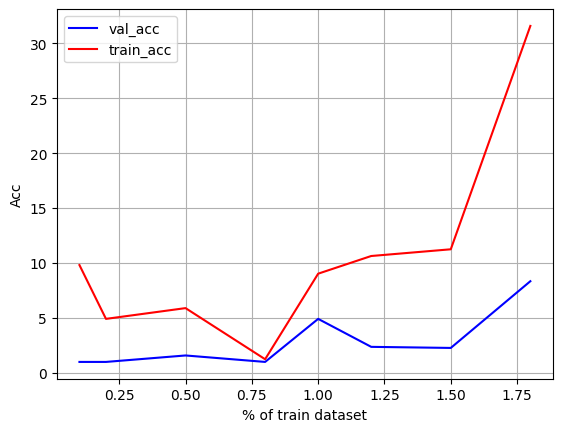

In [ ]:
print(val_acc)
print(train_acc)
tags = [0.1, 0.2, 0.5, 0.8, 1, 1.2, 1.5, 1.8]

plt.plot(tags, val_acc, label='val_acc', color='blue')
plt.plot(tags, train_acc, label='train_acc', color='red')

plt.xlabel('% of train dataset')
plt.ylabel('Acc')
plt.legend()
plt.grid(True)
plt.show()


## Baseline AlexNet

In [ ]:
alexnet = AlexNet()

In [ ]:
train_loader, val_loader, test_loader = load_data(limit_train = 1)

Epoch 1/15 | Train Loss: 4.6711998879909515 | Val Loss: 4.62508237361908
Epoch 2/15 | Train Loss: 4.627647191286087 | Val Loss: 4.625100314617157
Epoch 3/15 | Train Loss: 4.625601947307587 | Val Loss: 4.625263154506683
Epoch 4/15 | Train Loss: 4.631176024675369 | Val Loss: 4.621991395950317
Epoch 5/15 | Train Loss: 4.602734446525574 | Val Loss: 4.484833687543869
Epoch 6/15 | Train Loss: 4.37882986664772 | Val Loss: 4.253572911024094
Epoch 7/15 | Train Loss: 4.243696540594101 | Val Loss: 4.2054721266031265
Epoch 8/15 | Train Loss: 4.178410470485687 | Val Loss: 4.194653406739235
Epoch 9/15 | Train Loss: 4.130003973841667 | Val Loss: 4.114461272954941
Epoch 10/15 | Train Loss: 4.065693274140358 | Val Loss: 4.051880657672882
Epoch 11/15 | Train Loss: 4.025570437312126 | Val Loss: 4.006112426519394
Epoch 12/15 | Train Loss: 3.9160350412130356 | Val Loss: 3.9472581446170807
Epoch 13/15 | Train Loss: 3.8962710350751877 | Val Loss: 4.017805844545364
Epoch 14/15 | Train Loss: 3.8707324117422104

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,████▇▆▅▄▄▃▃▂▂▂▁
val_accuracy,████▇▅▄▄▄▃▃▂▃▂▁
epoch,15
train_loss,3.73858
val_accuracy,3.80432


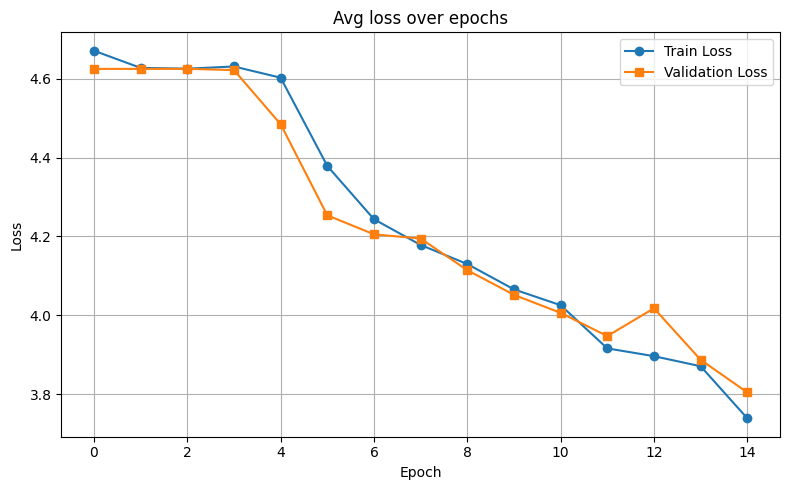

In [ ]:
train_model(alexnet, train_loader=train_loader, val_loader=val_loader, project_name = "Flowers102-AlexNet", run_name = "AlexNet", model_name = "AlexNet")

In [ ]:
print(get_acc(alexnet, test_loader))
print(get_acc(alexnet, val_loader))

6.163603838022443
8.235294117647058


## Hyperparameters experiments

In [ ]:
train_loader, val_loader, test_loader = load_data(limit_train = 0.5)

0.01


Epoch 1/5 | Train Loss: 834.963583111763 | Val Loss: 5.032927960157394
Epoch 2/5 | Train Loss: 4.7608755230903625 | Val Loss: 4.6787318885326385
Epoch 3/5 | Train Loss: 4.603836357593536 | Val Loss: 4.696890264749527
Epoch 4/5 | Train Loss: 4.503759801387787 | Val Loss: 4.733327925205231
Early stopping


epoch,▁▁▁▁
train_loss,█▁▁▁
val_accuracy,█▁▁▂
epoch,5
train_loss,4.50376
val_accuracy,4.73333


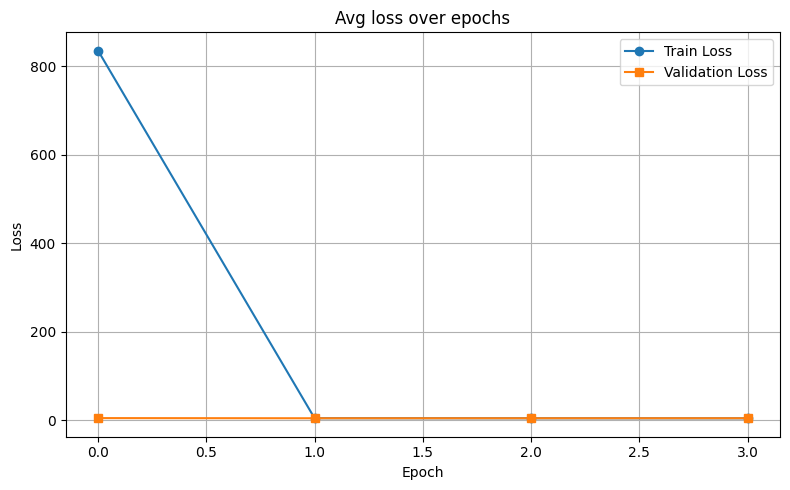

0.001


Epoch 1/5 | Train Loss: 4.585964143276215 | Val Loss: 4.638115763664246
Epoch 2/5 | Train Loss: 4.5197833776474 | Val Loss: 4.807780027389526
Epoch 3/5 | Train Loss: 4.471695005893707 | Val Loss: 4.693560600280762
Epoch 4/5 | Train Loss: 4.452328026294708 | Val Loss: 4.642361998558044
Epoch 5/5 | Train Loss: 4.431419849395752 | Val Loss: 4.6663020849227905


epoch,▁▁▁▁▁
train_loss,█▅▃▂▁
val_accuracy,▁█▃▁▂
epoch,5
train_loss,4.43142
val_accuracy,4.6663


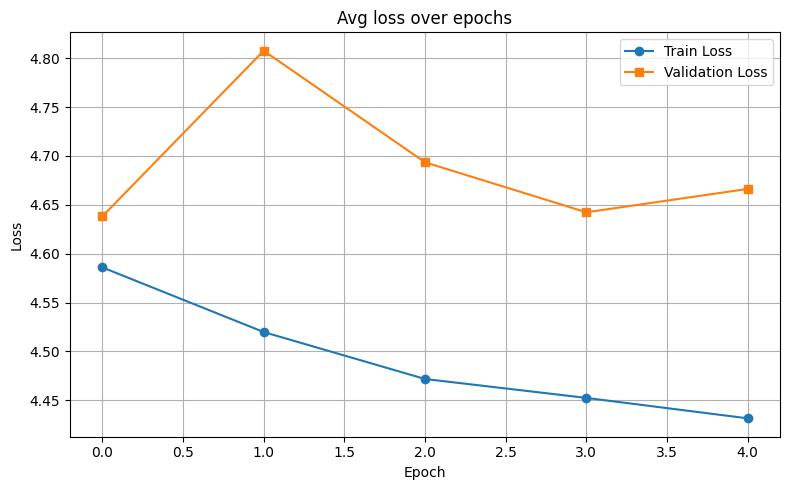

0.0001


Epoch 1/5 | Train Loss: 4.598055005073547 | Val Loss: 4.662089407444
Epoch 2/5 | Train Loss: 4.50274658203125 | Val Loss: 4.7826768308877945
Epoch 3/5 | Train Loss: 4.449464499950409 | Val Loss: 4.76422806084156
Epoch 4/5 | Train Loss: 4.422724664211273 | Val Loss: 4.798056498169899
Epoch 5/5 | Train Loss: 4.396965980529785 | Val Loss: 4.802489593625069
Early stopping


epoch,▁▁▁▁▁
train_loss,█▅▃▂▁
val_accuracy,▁▇▆██
epoch,5
train_loss,4.39697
val_accuracy,4.80249


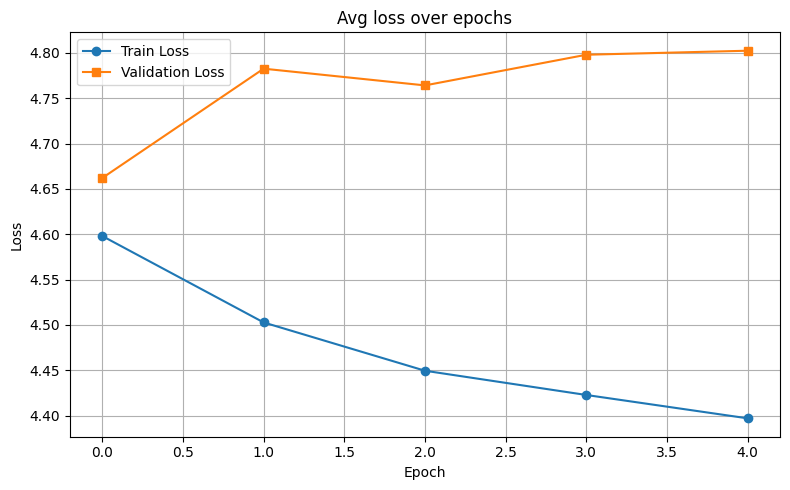

[0.5854610505773297, 2.5207350788746137, 2.2930557814278747]


In [ ]:
lr_tests = [0.01, 0.001, 0.0001]
results = []
for lr in lr_tests:
  print(lr)
  model = test_model()
  train_model(model, lr = lr, epoch = 5, train_loader=train_loader, val_loader=val_loader, project_name = "Flowers102-hyperparameters", run_name = "Test-lr" + str(lr), model_name = "Test-lr" + str(lr))
  results.append(get_acc(model, test_loader))

print(results)

3


Epoch 1/3 | Train Loss: 4.58205783367157 | Val Loss: 4.6578720808029175
Epoch 2/3 | Train Loss: 4.490485787391663 | Val Loss: 4.623656362295151
Epoch 3/3 | Train Loss: 4.519117116928101 | Val Loss: 4.704211920499802


epoch,▁▁▁
train_loss,█▁▃
val_accuracy,▄▁█
epoch,3
train_loss,4.51912
val_accuracy,4.70421


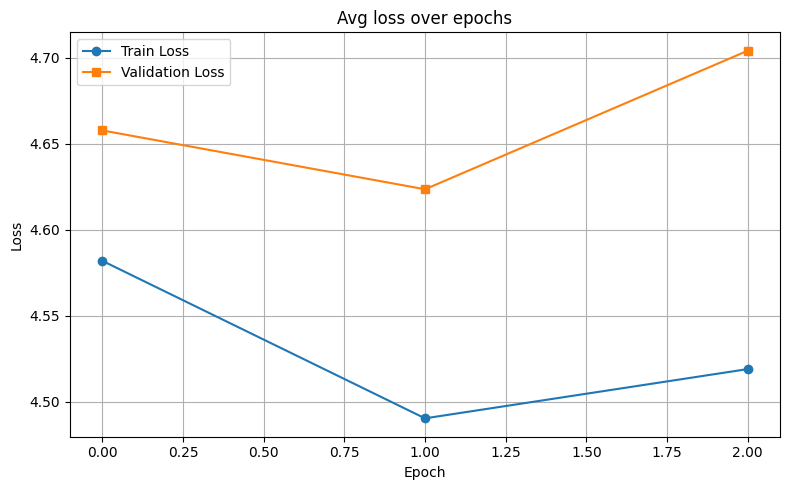

5


Epoch 1/5 | Train Loss: 4.58136248588562 | Val Loss: 4.6443246603012085
Epoch 2/5 | Train Loss: 4.4494375586509705 | Val Loss: 4.702713072299957
Epoch 3/5 | Train Loss: 4.301703333854675 | Val Loss: 4.662195950746536
Epoch 4/5 | Train Loss: 4.214697241783142 | Val Loss: 4.6135483384132385
Epoch 5/5 | Train Loss: 4.1399471163749695 | Val Loss: 4.578480049967766


epoch,▁▁▁▁▁
train_loss,█▆▄▂▁
val_accuracy,▅█▆▃▁
epoch,5
train_loss,4.13995
val_accuracy,4.57848


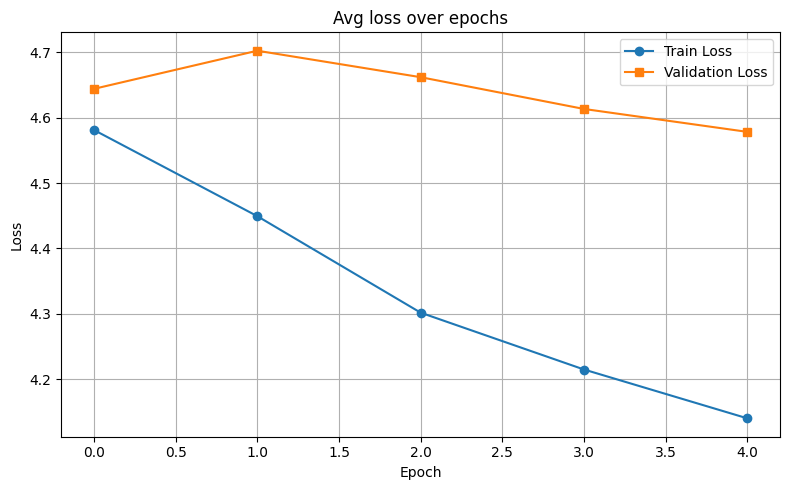

10


Epoch 1/10 | Train Loss: 4.6005794405937195 | Val Loss: 4.632233619689941
Epoch 2/10 | Train Loss: 4.5404897928237915 | Val Loss: 4.670778036117554
Epoch 3/10 | Train Loss: 4.491733610630035 | Val Loss: 4.751351058483124
Epoch 4/10 | Train Loss: 4.463552355766296 | Val Loss: 4.665454983711243
Epoch 5/10 | Train Loss: 4.419808924198151 | Val Loss: 4.726932793855667
Epoch 6/10 | Train Loss: 4.325451195240021 | Val Loss: 4.66251266002655
Epoch 7/10 | Train Loss: 4.2491774559021 | Val Loss: 4.73948709666729
Epoch 8/10 | Train Loss: 4.175804674625397 | Val Loss: 4.666162490844727
Epoch 9/10 | Train Loss: 4.079414963722229 | Val Loss: 4.701292902231216
Epoch 10/10 | Train Loss: 3.9850239157676697 | Val Loss: 4.5513004809618


epoch,▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▆▆▅▄▃▂▁
val_accuracy,▄▅█▅▇▅█▅▆▁
epoch,10
train_loss,3.98502
val_accuracy,4.5513


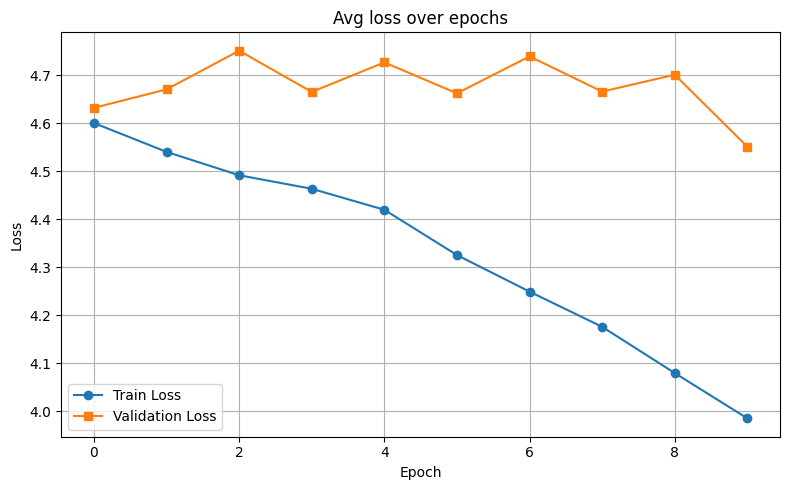

[1.0570824524312896, 2.699625955439909, 3.122458936412425]


In [ ]:
epoch_tests = [3, 5, 10]
results = []
for epoch in epoch_tests:
  print(epoch)
  model = test_model()
  train_model(model, epoch = epoch, train_loader=train_loader, val_loader=val_loader, project_name = "Flowers102-hyperparameters", run_name = "Test-epoch" + str(epoch), model_name = "Test-epoch" + str(epoch))
  results.append(get_acc(model, test_loader))

print(results)

Adam


Epoch 1/10 | Train Loss: 4.590344667434692 | Val Loss: 4.685108810663223
Epoch 2/10 | Train Loss: 4.500954687595367 | Val Loss: 4.789002150297165
Epoch 3/10 | Train Loss: 4.485261678695679 | Val Loss: 4.703461915254593
Epoch 4/10 | Train Loss: 4.470253646373749 | Val Loss: 4.720469683408737
Epoch 5/10 | Train Loss: 4.413474142551422 | Val Loss: 4.763558849692345
Early stopping


epoch,▁▁▁▁▁
train_loss,█▄▄▃▁
val_accuracy,▁█▂▃▆
epoch,10
train_loss,4.41347
val_accuracy,4.76356


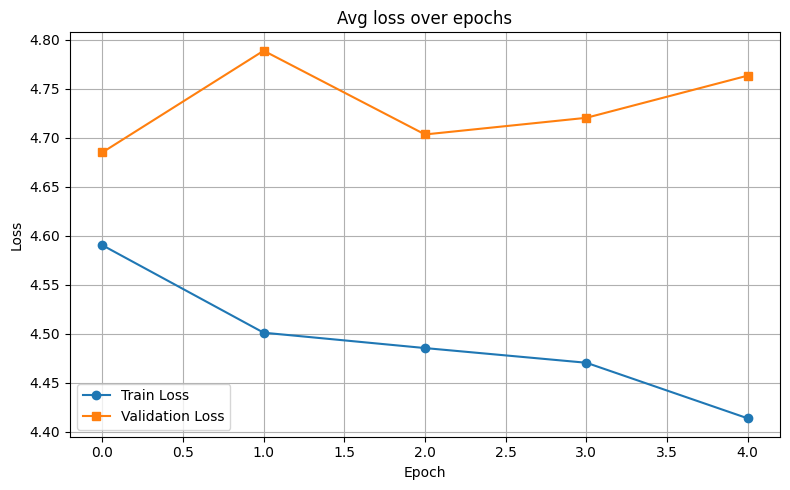

SGD


Epoch 1/10 | Train Loss: 4.6251713037490845 | Val Loss: 4.625014781951904
Epoch 2/10 | Train Loss: 4.625120937824249 | Val Loss: 4.62501448392868
Epoch 3/10 | Train Loss: 4.625043153762817 | Val Loss: 4.6250139772892
Epoch 4/10 | Train Loss: 4.624978482723236 | Val Loss: 4.625013500452042
Epoch 5/10 | Train Loss: 4.624904990196228 | Val Loss: 4.625012785196304
Epoch 6/10 | Train Loss: 4.624838054180145 | Val Loss: 4.625012099742889
Epoch 7/10 | Train Loss: 4.624772012233734 | Val Loss: 4.625011503696442
Epoch 8/10 | Train Loss: 4.624710857868195 | Val Loss: 4.625010937452316
Epoch 9/10 | Train Loss: 4.624635934829712 | Val Loss: 4.62501060962677
Epoch 10/10 | Train Loss: 4.624559938907623 | Val Loss: 4.625010311603546


epoch,▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▆▅▄▃▃▂▁
val_accuracy,█▇▆▆▅▃▃▂▁▁
epoch,10
train_loss,4.62456
val_accuracy,4.62501


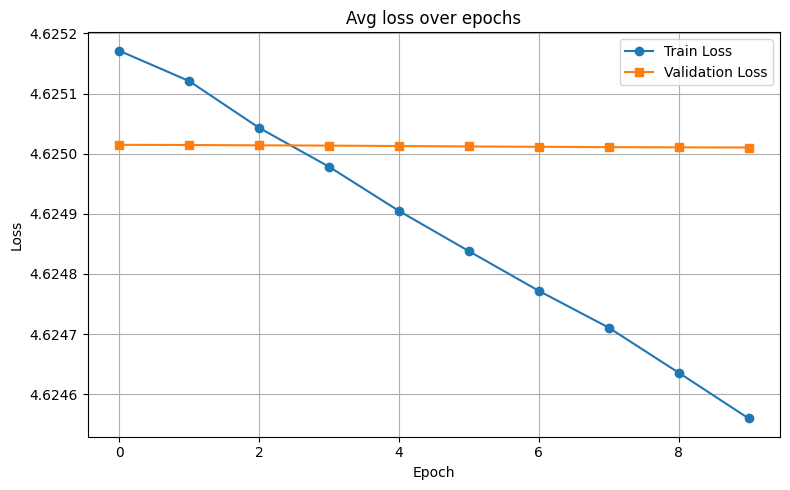

[1.5774922751666938, 1.7889087656529516]


In [ ]:
optimize_tests = ["Adam", "SGD"]
results = []
for optimizer in optimize_tests:
  print(optimizer)
  model = test_model()
  train_model(model, optimizer = optimizer, epoch = 5, train_loader=train_loader, val_loader=val_loader, project_name = "Flowers102-hyperparameters", run_name = "Test-optimizer" + str(optimizer), model_name = "Test-optimizer" + str(optimizer))
  results.append(get_acc(model, test_loader))

print(results)

32


Epoch 1/5 | Train Loss: 4.7721720933914185 | Val Loss: 4.654318556189537
Epoch 2/5 | Train Loss: 4.567334741353989 | Val Loss: 4.682550683617592
Epoch 3/5 | Train Loss: 4.558480769395828 | Val Loss: 4.661382973194122
Epoch 4/5 | Train Loss: 4.545097917318344 | Val Loss: 4.722548045217991
Epoch 5/5 | Train Loss: 4.532229274511337 | Val Loss: 4.678410559892654


epoch,▁▁▁▁▁
train_loss,█▂▂▁▁
val_accuracy,▁▄▂█▃
epoch,5
train_loss,4.53223
val_accuracy,4.67841


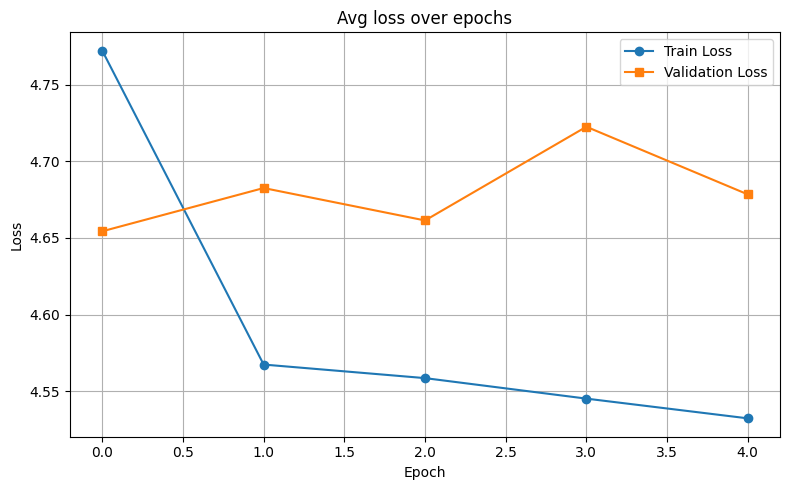

64


Epoch 1/5 | Train Loss: 4.612670958042145 | Val Loss: 4.644546002149582
Epoch 2/5 | Train Loss: 4.528798162937164 | Val Loss: 4.692392140626907
Epoch 3/5 | Train Loss: 4.508436024188995 | Val Loss: 4.6932885348796844
Epoch 4/5 | Train Loss: 4.491519570350647 | Val Loss: 4.918778225779533
Early stopping


epoch,▁▁▁▁
train_loss,█▃▂▁
val_accuracy,▁▂▂█
epoch,5
train_loss,4.49152
val_accuracy,4.91878


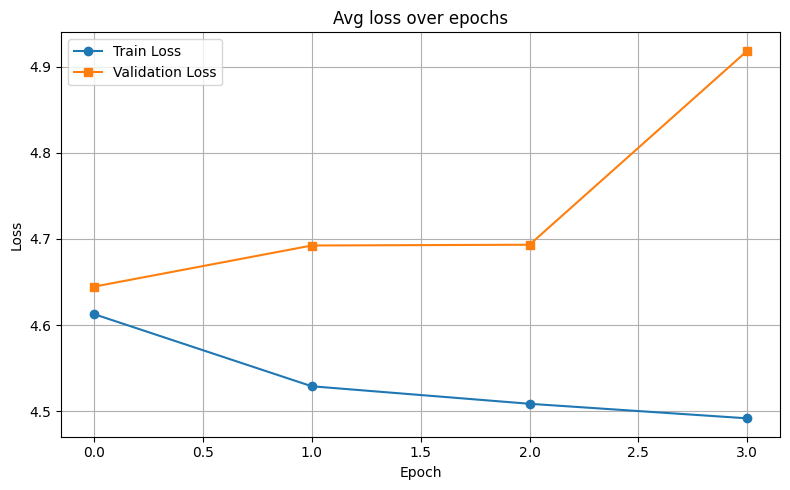

128


Epoch 1/5 | Train Loss: 5.120329141616821 | Val Loss: 4.632991433143616
Epoch 2/5 | Train Loss: 4.581620931625366 | Val Loss: 4.6335766315460205
Epoch 3/5 | Train Loss: 4.518417119979858 | Val Loss: 4.877997636795044
Epoch 4/5 | Train Loss: 4.49640691280365 | Val Loss: 4.74884158372879
Epoch 5/5 | Train Loss: 4.4774370193481445 | Val Loss: 4.709251761436462


epoch,▁▁▁▁▁
train_loss,█▂▁▁▁
val_accuracy,▁▁█▄▃
epoch,5
train_loss,4.47744
val_accuracy,4.70925


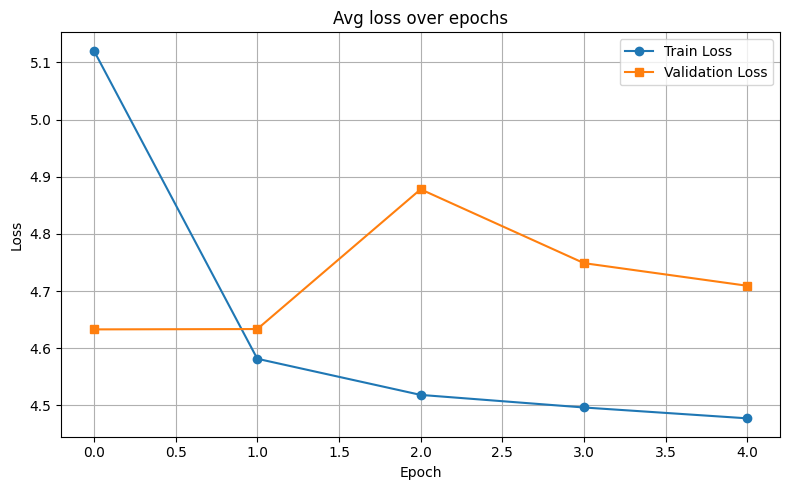

[1.154659294194178, 0.7643519271426248, 0.3252561392096276]


In [ ]:
batch_size_tests = [32, 64, 128]
results = []

for batch_size in batch_size_tests:
  train_loader, val_loader, test_loader = load_data(limit_train = 0.5, batch_size=batch_size)
  print(batch_size)
  model = test_model()
  train_model(model, train_loader=train_loader, epoch = 5, val_loader=val_loader, project_name = "Flowers102-hyperparameters", run_name = "Test-batch_size" + str(batch_size), model_name = "Test-batch_size" + str(batch_size))
  results.append(get_acc(model, test_loader))

print(results)

## Batch norm and Dropout

Epoch 1/5 | Train Loss: 4.637314736843109 | Val Loss: 4.650656491518021
Epoch 2/5 | Train Loss: 4.542107045650482 | Val Loss: 4.66123029589653
Epoch 3/5 | Train Loss: 4.531762540340424 | Val Loss: 4.727352321147919
Epoch 4/5 | Train Loss: 4.513977348804474 | Val Loss: 4.664673537015915
Epoch 5/5 | Train Loss: 4.5019248723983765 | Val Loss: 4.768779307603836


epoch,▁▁▁▁▁
train_loss,█▃▃▂▁
val_accuracy,▁▂▆▂█
epoch,5
train_loss,4.50192
val_accuracy,4.76878


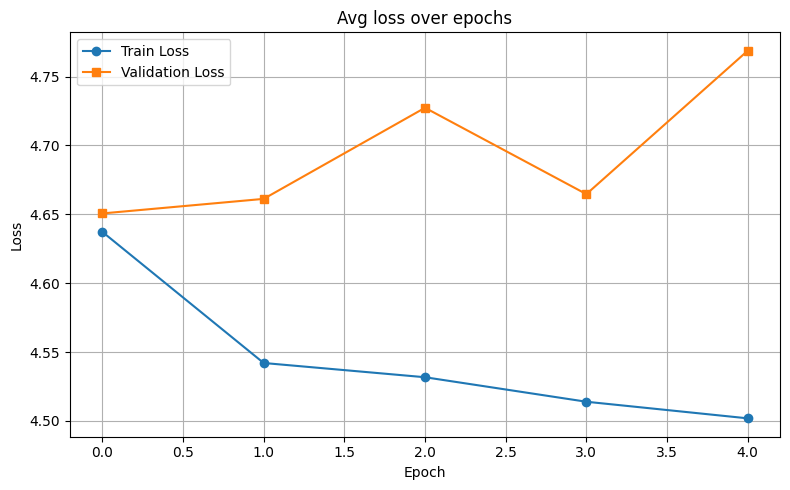

0.3


Epoch 1/5 | Train Loss: 4.898990988731384 | Val Loss: 4.625413000583649
Epoch 2/5 | Train Loss: 4.617993474006653 | Val Loss: 4.626276761293411
Epoch 3/5 | Train Loss: 4.6060983538627625 | Val Loss: 4.6264927983284
Epoch 4/5 | Train Loss: 4.60960453748703 | Val Loss: 4.630493193864822
Early stopping


epoch,▁▁▁▁
train_loss,█▁▁▁
val_accuracy,▁▂▂█
epoch,5
train_loss,4.6096
val_accuracy,4.63049


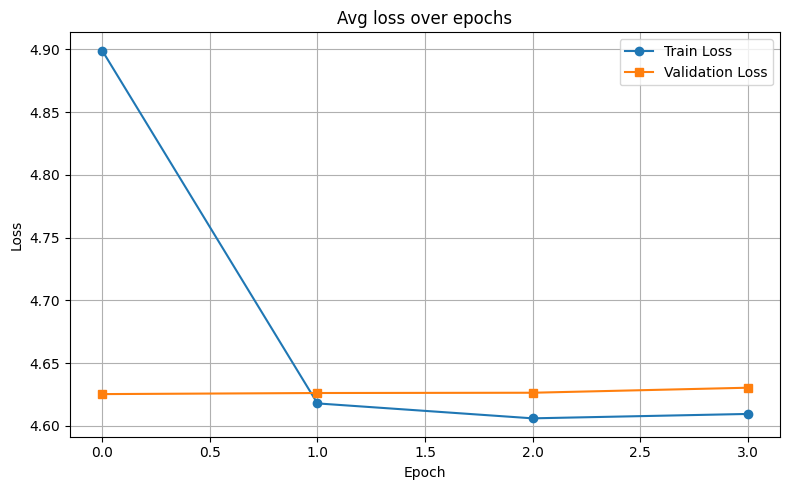

0.5


Epoch 1/5 | Train Loss: 5.4696279764175415 | Val Loss: 4.624988347291946
Epoch 2/5 | Train Loss: 4.625120043754578 | Val Loss: 4.6249911189079285
Epoch 3/5 | Train Loss: 4.625925660133362 | Val Loss: 4.624977469444275
Epoch 4/5 | Train Loss: 4.623648643493652 | Val Loss: 4.624974489212036
Epoch 5/5 | Train Loss: 4.622629880905151 | Val Loss: 4.625003159046173


epoch,▁▁▁▁▁
train_loss,█▁▁▁▁
val_accuracy,▄▅▂▁█
epoch,5
train_loss,4.62263
val_accuracy,4.625


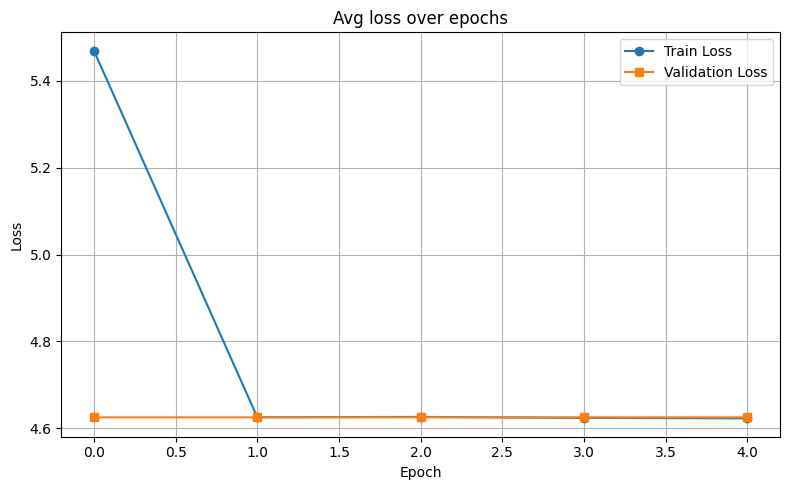

[0.3252561392096276, 1.7889087656529516, 0.6342494714587738]


In [ ]:
train_loader, val_loader, test_loader = load_data(limit_train = 0.5)

baseline = test_model()
train_model(baseline, epoch = 5, train_loader=train_loader, val_loader=val_loader, project_name = "Flowers102-hyperparameters", run_name = str("Test-baseline"), model_name = str("Test-baseline"))
baseline_acc = get_acc(baseline, test_loader)


test_drop_model = lambda cnn_drop_out, dense_drop_out: CNN(
    cnn_nr=4,
    kernel_sizes=[5, 5, 3, 3, 3],
    channels=[3, 16, 32, 64, 128],
    dropout_cnn=cnn_drop_out,
    dropout_dense=dense_drop_out,
    dense_nr=3,
    dense_sizes=[21632, 5000, 1024,102])


drop_out_tests = [0.3, 0.5]
results = [baseline_acc]

for drop_out in drop_out_tests:
  print(drop_out)
  cnn_drop_out = [drop_out] * 4
  dense_drop_out = [drop_out] * 3
  model = test_drop_model(cnn_drop_out, dense_drop_out )
  train_model(model, epoch = 5, train_loader=train_loader, val_loader=val_loader, project_name = "Flowers102-hyperparameters", run_name = "Test-drop_out" + str(drop_out), model_name = "Test-drop_out" + str(drop_out))
  results.append(get_acc(model, test_loader))

print(results)

## Data augmentation


Epoch 1/5 | Train Loss: 4.56559282541275 | Val Loss: 4.676149427890778
Epoch 2/5 | Train Loss: 4.497205495834351 | Val Loss: 4.792956307530403
Epoch 3/5 | Train Loss: 4.465090394020081 | Val Loss: 4.843820035457611
Epoch 4/5 | Train Loss: 4.431843936443329 | Val Loss: 4.640251114964485
Epoch 5/5 | Train Loss: 4.3852763175964355 | Val Loss: 4.657086819410324


epoch,▁▁▁▁▁
train_loss,█▅▄▃▁
val_accuracy,▂▆█▁▂
epoch,5
train_loss,4.38528
val_accuracy,4.65709


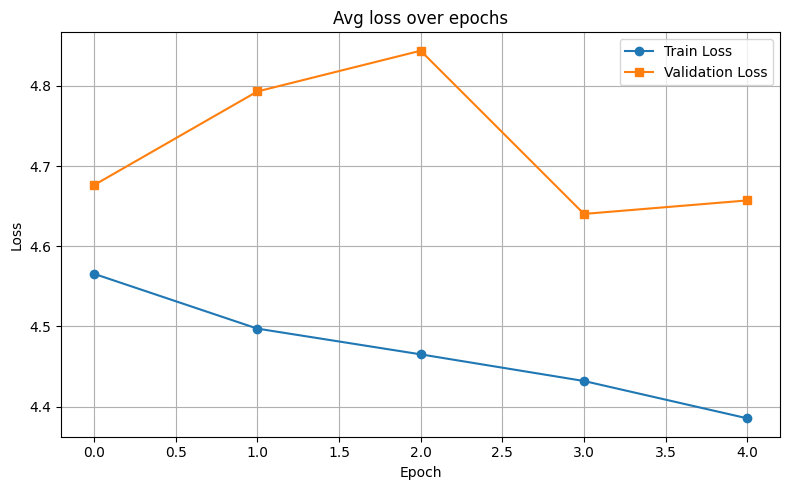

Epoch 1/5 | Train Loss: 4.640418529510498 | Val Loss: 4.655678540468216
Epoch 2/5 | Train Loss: 4.533729612827301 | Val Loss: 4.683432251214981
Epoch 3/5 | Train Loss: 4.519669055938721 | Val Loss: 4.7366781532764435
Epoch 4/5 | Train Loss: 4.490871071815491 | Val Loss: 4.729508578777313
Epoch 5/5 | Train Loss: 4.459416747093201 | Val Loss: 4.75838702917099


epoch,▁▁▁▁▁
train_loss,█▄▃▂▁
val_accuracy,▁▃▇▆█
epoch,5
train_loss,4.45942
val_accuracy,4.75839


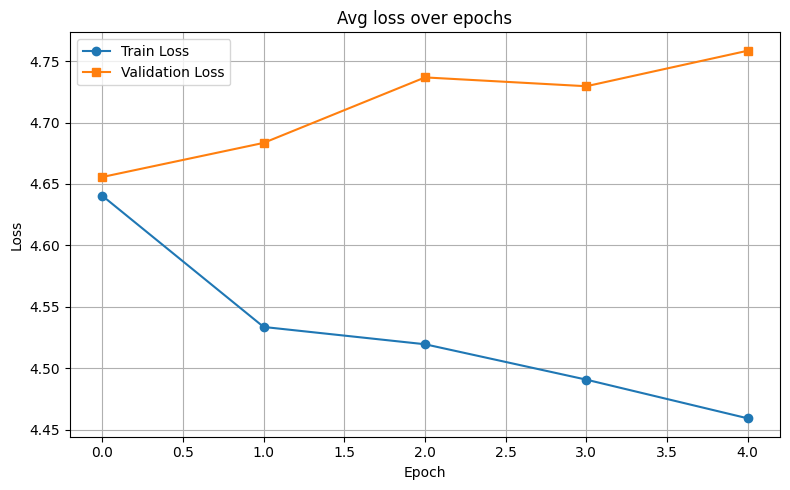

In [ ]:
train_loader, val_loader, test_loader = load_data(limit_train = 0.5)
model_without_augmentation = test_model()
train_model(model_without_augmentation, epoch = 5, train_loader=train_loader, val_loader=val_loader)

train_loader, val_loader, test_loader = load_data(limit_train = 0.5, augmentation = True)
model_with_augmentation = test_model()
train_model(model_with_augmentation, epoch = 5, train_loader=train_loader, val_loader=val_loader)

print(f"without augmentation: {get_acc(model_without_augmentation, test_loader)}")
print(f"with augmentation: {get_acc(model_with_augmentation, test_loader)}")
